# Clustering  
In this section, we build a full preprocessing pipeline and apply clustering to obtain the results.

In [6]:
# --- 📦 Standard Python Libraries --- #
import os                            # For file and directory operations
from platform import python_version  # To check Python version

# --- 📊 Data Manipulation and Visualization --- #
import pandas as pd                  # For data manipulation
import numpy as np                   # For numerical operations

import matplotlib                    # For configuring plotting backend
import matplotlib.pyplot as plt      # For plotting figures
import seaborn as sns                # For statistical visualizations

# Enable inline plotting in Jupyter Notebook
%matplotlib inline

# Set global Seaborn theme for consistent styling across plots
sns.set_theme(palette="bright")

# --- 🧪 Statistical Testing --- #
import scipy                         # Core scientific computing package
from scipy.stats import (
    ttest_ind,                       # Independent t-test
    mannwhitneyu                     # Mann–Whitney U test (non-parametric)
)

# --- ⚙️ Machine Learning & Profiling --- #
import sklearn                       # Scikit-learn machine learning library
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans

from ydata_profiling import ProfileReport  # For automated EDA reports

# --- 📁 Project Configuration --- #
from config import (
    project_folder,     # Main project directory
    original_data,      # Path to raw/original data
    cleaned_data,       # Path to cleaned/preprocessed data
    models_folder,      # Path to store/load trained models
    rgb_color,          # Custom RGB color for plots
    palette,            # Custom palette for plot hues
    random_state
)

# --- 💾 Saving and Loading Models --- #
import joblib

In [7]:
# Get data
df = pd.read_csv(cleaned_data)
print(df.head())

   Gender  Age  Annual Income (k$)  Spending Score (1-100)
0    Male   19                  15                      39
1    Male   21                  15                      81
2  Female   20                  16                       6
3  Female   23                  16                      77
4  Female   31                  17                      40


In [8]:
# --- 🛠️ Data Preprocessing Pipeline --- #

# 1) Declare which columns are numeric and which are categorical
numeric = ["Age", "Annual Income (k$)", "Spending Score (1-100)"]
categorical = ["Gender"]

n_clusters = 5

# 2) Preprocessing: standardize and one-hot encode
preprocessing = ColumnTransformer(
    transformers=[
        ("standard", StandardScaler(), numeric),
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False), categorical)
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

# 3) Create pipeline: preprocessing → PCA → KMeans
pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("pca", PCA(n_components=3, random_state=random_state)),
    ("clustering", KMeans(n_clusters=n_clusters, random_state=random_state, n_init=10))
])

# 4) Fit pipeline and predict clusters
df["cluster"] = pipeline.fit_predict(df)

# 5) Transform data for inspection (optional)
df_transformed = pipeline.named_steps["pca"].transform(
    pipeline.named_steps["preprocessing"].transform(df)
)

# 6) Create DataFrame with PCA components
df_scaled = pd.DataFrame(
    df_transformed,
    columns=[f"PC{i+1}" for i in range(df_transformed.shape[1])],
    index=df.index
)

# 7) Quick check
df_scaled.head()


,PC1,PC2,PC3
0,-0.575724,-1.684874,-1.315210
1,-1.623595,-1.726481,-0.060149
2,0.279614,-1.725314,-2.182574
3,-1.511064,-1.796205,-0.080242
4,-0.095468,-1.707347,-0.690684


In [9]:
pipeline # Check the pipeline object for details

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('standard', StandardScaler(),
                                                  ['Age', 'Annual Income (k$)',
                                                   'Spending Score (1-100)']),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Gender'])],
                                   verbose_feature_names_out=False)),
                ('pca', PCA(n_components=3, random_state=42)),
                ('clustering',
                 KMeans(n_clusters=5, n_init=10, random_state=42))])

In [10]:
# Saving the pipeline model
joblib.dump(pipeline, "../Models/pipeline_preprocessing_pca_clustering.pkl")

['../Models/pipeline_preprocessing_pca_clustering.pkl']

In [11]:
# Get the names of the features after the entire pipeline
pipeline.get_feature_names_out()

array(['kmeans0', 'kmeans1', 'kmeans2', 'kmeans3', 'kmeans4'],
      dtype=object)

In [12]:
# Get the cluster labels from the KMeans step in the pipeline
pipeline["clustering"].labels_

array([1, 3, 1, 3, 1, 3, 1, 3, 0, 3, 0, 3, 0, 3, 1, 3, 1, 3, 0, 3, 1, 3,
       0, 3, 0, 3, 0, 3, 1, 3, 0, 3, 0, 3, 0, 3, 0, 3, 1, 3, 0, 3, 0, 1,
       0, 3, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1,
       1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 4, 1, 4, 2, 4, 2, 4, 2, 4,
       1, 4, 2, 4, 2, 4, 2, 4, 2, 4, 1, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4,
       2, 4, 2, 4, 2, 4, 0, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4,
       2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4, 2, 4,
       2, 4], dtype=int32)

In [13]:
# Create a copy of the original DataFrame and add the cluster labels from the pipeline
df_clustered = df.copy()
df_clustered["cluster"] = pipeline["clustering"].labels_

df_clustered.head()

,Gender,Age,Annual Income (k$),Spending Score (1-100),cluster
0,Male,19,15,39,1
1,Male,21,15,81,3
2,Female,20,16,6,1
3,Female,23,16,77,3
4,Female,31,17,40,1


In [15]:
df_scaled.to_csv("../data/Mall_Customers_no_CustomerID_scaled.csv", index=False)

# Graphs

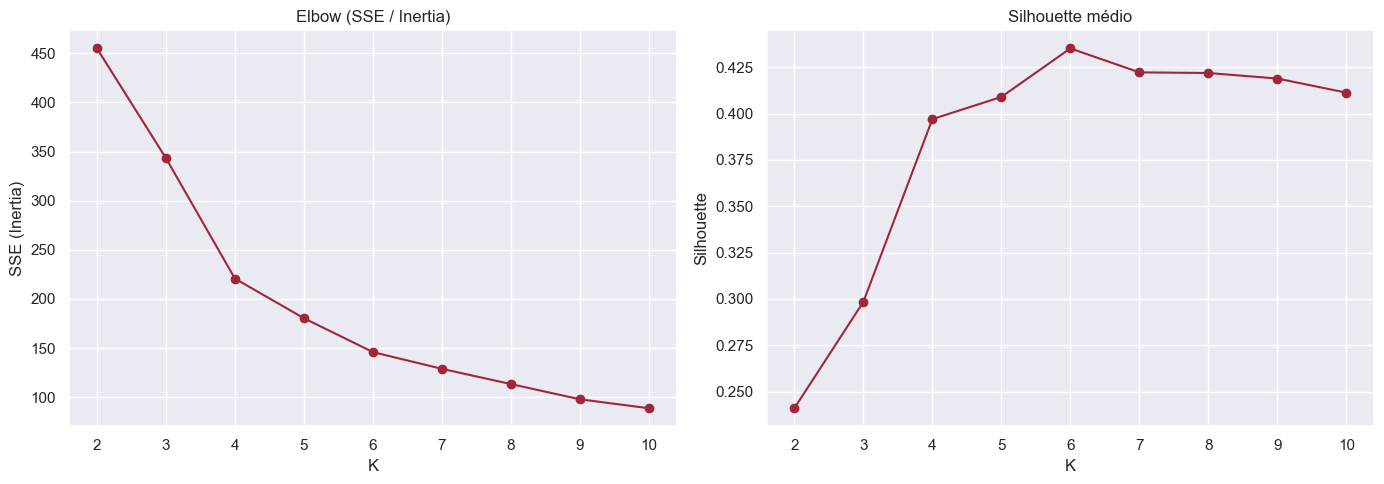

,K,inertia,silhouette,calinski_harabasz,davies_bouldin
0,2,455.070302,0.241080,63.058565,1.655163
1,3,343.330671,0.298427,73.637257,1.271612
2,4,220.693956,0.396971,112.288205,0.905499
3,5,180.368315,0.408958,113.418172,0.887702
4,6,145.873556,0.435124,120.790269,0.815104
5,7,128.837656,0.422212,117.634258,0.853891
6,8,113.328777,0.421851,117.787350,0.788467
7,9,97.827899,0.418872,122.555621,0.857465
8,10,88.712399,0.411261,121.672386,0.840901


In [16]:
from functions import graficos_elbow_silhouette

graficos_elbow_silhouette(df_scaled)

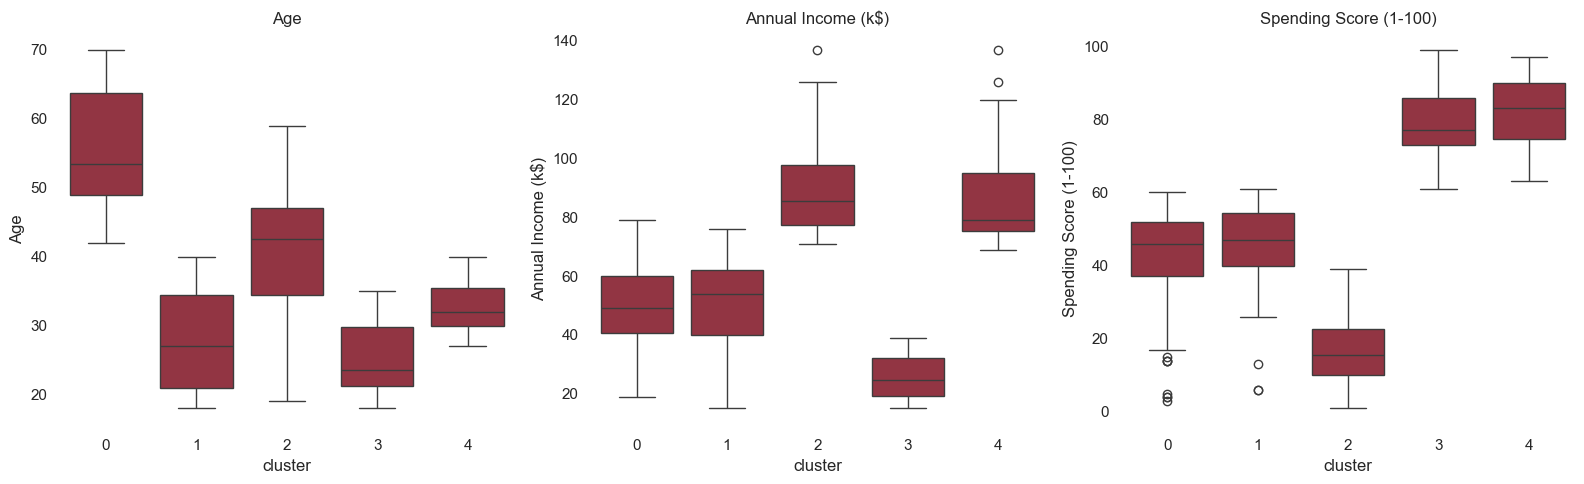

In [17]:
# Boxplots for each numeric feature by cluster
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 5))

numeric_cols = [col for col in df_clustered.select_dtypes("number").columns if col != "cluster"]
n_clusters = df_clustered["cluster"].nunique()

for ax, col in zip(axs, numeric_cols):
    sns.boxplot(
        data=df_clustered,
        x="cluster",
        y=col,
        hue="cluster",  # necessário para usar palette
        legend=False,   # evita legenda duplicada
        palette=[rgb_color] * n_clusters,
        ax=ax
    )
    ax.set_title(col)
    ax.grid(False)
    ax.set_facecolor("white")

plt.tight_layout()
plt.show()



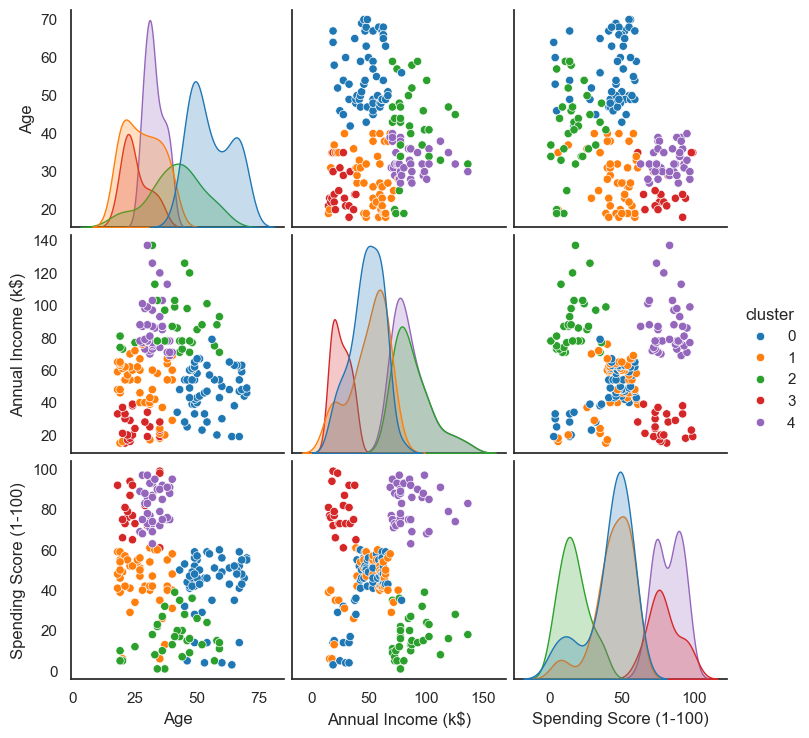

In [18]:
# Generate a pairplot with KDE on the diagonal, color-coded by cluster using the 'tab10' palette

# Set style without gridlines
sns.set_style("white")

# Create a pairplot grouped by cluster with a clean background and distinct colors
sns.pairplot(
    df_clustered,
    diag_kind="kde",
    hue="cluster",
    palette="tab10"
)

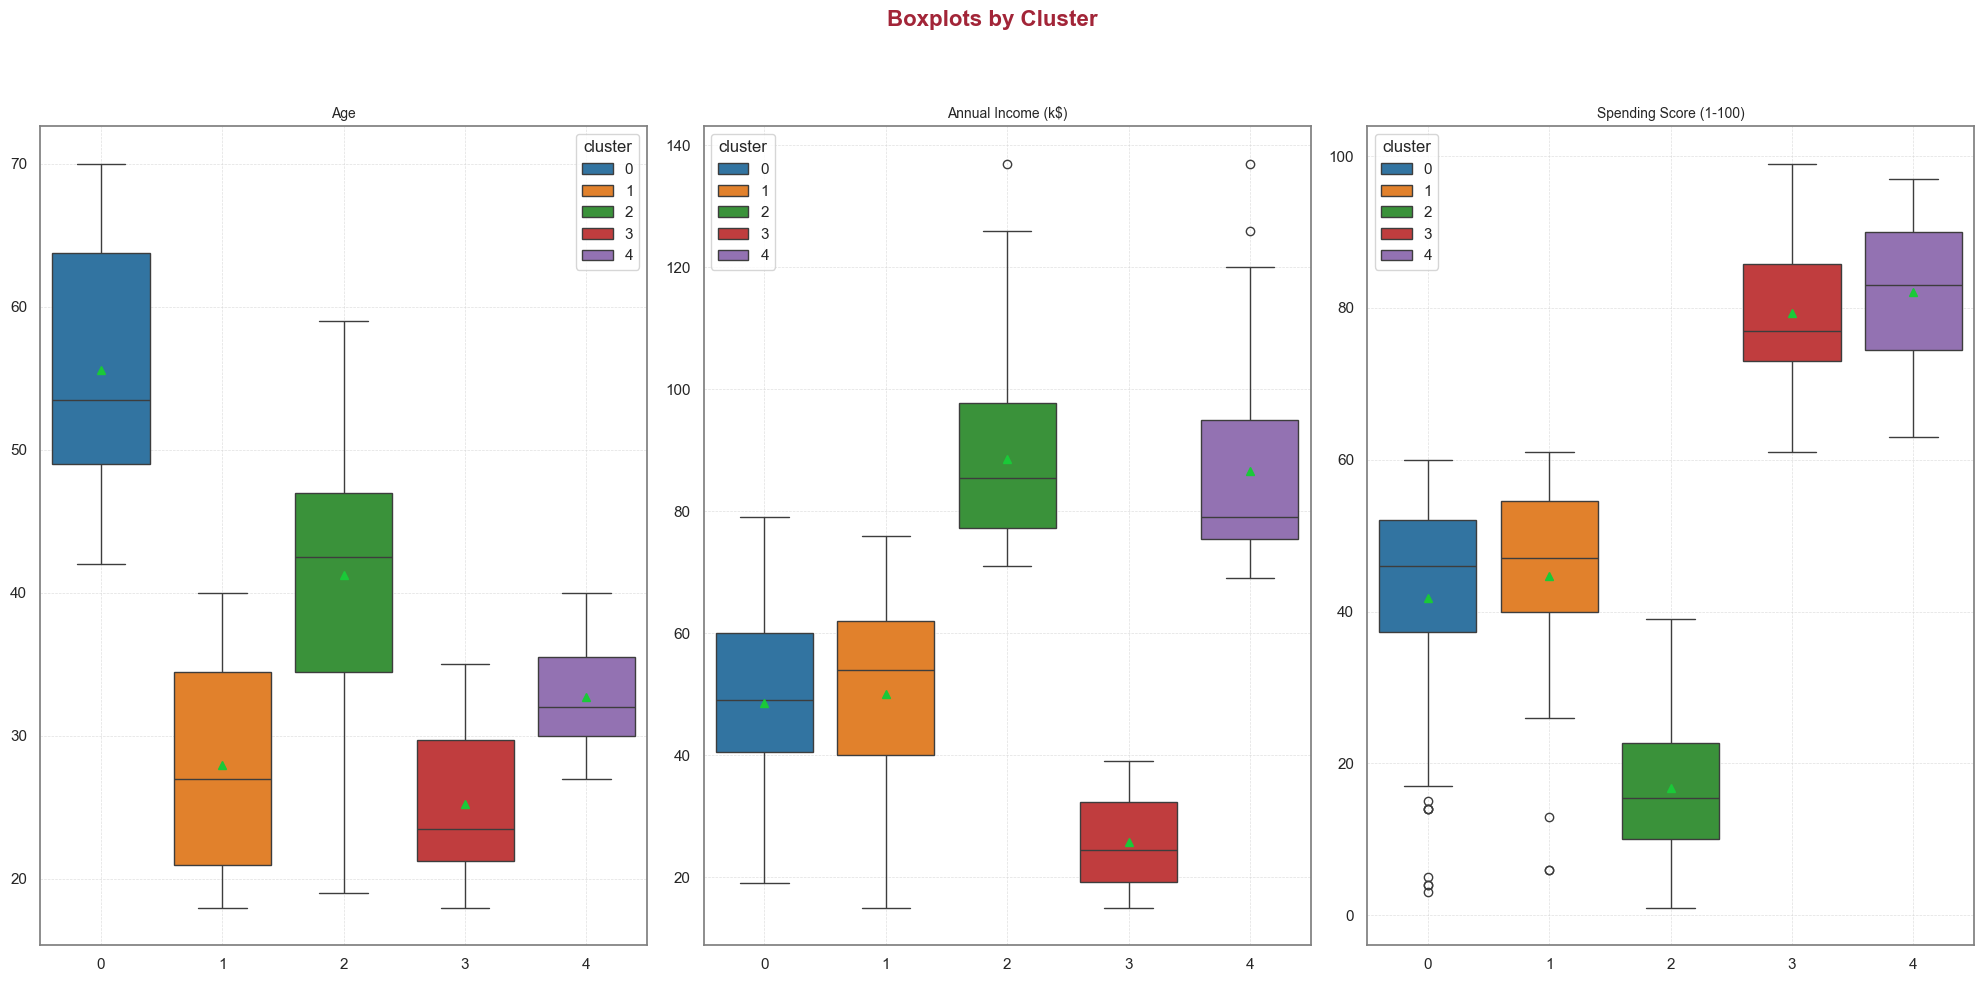

In [19]:
# Generate vertical boxplots for numeric variables by cluster


# Set clean style
sns.set_style("whitegrid")
plt.rcParams.update({
    "axes.facecolor": "white",
    "figure.facecolor": "white",
    "grid.color": "lightgray",
    "grid.linewidth": 0.5,
    "axes.edgecolor": "gray"
})

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(20, 10))

# Add main title
fig.suptitle("Boxplots by Cluster", fontsize=16, fontweight='bold', color=rgb_color)

# Plot each numeric variable as vertical boxplot with hue = cluster
for ax, column in zip(axs.flatten(), df_clustered.select_dtypes("number").drop(columns="cluster").columns):
    sns.boxplot(
        x="cluster",
        y=column,
        data=df_clustered,
        ax=ax,
        showmeans=True,
        hue="cluster",
        linewidth=1,
        palette="tab10"
    ) 
    ax.set_title(column, fontsize=10)
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    ax.set_facecolor("white")
    ax.set_xlabel("")
    ax.set_ylabel("")

# Adjust layout to avoid overlap
plt.tight_layout(rect=[0, 0, 1, 0.94])
plt.show()


In [21]:
# Calculate the percentage of observations in each cluster, sorted by cluster label
print(df_clustered["cluster"].value_counts(normalize=True).mul(100).sort_index())

cluster
0    29.0
1    23.5
2    17.0
3    11.0
4    19.5
Name: proportion, dtype: float64


In [28]:
# Count the number of observations in each cluster, grouped by Gender
df_clustered.groupby(["cluster", "Gender"]).size().reset_index(name="Count")


,cluster,Gender,Count
0,0,Female,33
1,0,Male,25
2,1,Female,31
3,1,Male,16
4,2,Female,14
5,2,Male,20
6,3,Female,13
7,3,Male,9
8,4,Female,21
9,4,Male,18


In [19]:
pipeline["preprocessing"].get_feature_names_out() # Get the names of the features after preprocessing

array(['Age', 'Annual Income (k$)', 'Spending Score (1-100)',
       'Gender_Female', 'Gender_Male'], dtype=object)

In [29]:
# Access PCA components in the pipeline:
pipeline["pca"].components_

array([[ 0.70508424, -0.03921531, -0.70473508, -0.04830549,  0.04830549],
       [ 0.02024387,  0.996115  , -0.02730038, -0.05744471,  0.05744471],
       [ 0.70661643,  0.00434967,  0.70753413, -0.00590595,  0.00590595]])

In [30]:
# Get the names of the features after PCA
pipeline["pca"].get_feature_names_out()

array(['pca0', 'pca1', 'pca2'], dtype=object)

In [31]:
# Get the cluster centers from the KMeans step in the pipeline
pipeline["clustering"].cluster_centers_

array([[ 1.09281997, -0.42702742,  0.61346816],
       [-0.39283157, -0.42287385, -0.70807382],
       [ 1.00944112,  1.11828568, -0.78954352],
       [-1.4357643 , -1.37856558,  0.10638215],
       [-1.2219143 ,  0.94742028,  0.56929202]])

In [32]:
# Get the names of the features before the entire pipeline
pipeline[:-1].get_feature_names_out()

array(['pca0', 'pca1', 'pca2'], dtype=object)

In [33]:
# 
pipeline[:-1]

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('standard', StandardScaler(),
                                                  ['Age', 'Annual Income (k$)',
                                                   'Spending Score (1-100)']),
                                                 ('onehot',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False),
                                                  ['Gender'])],
                                   verbose_feature_names_out=False)),
                ('pca', PCA(n_components=3, random_state=42))])

In [34]:
# Cria um DataFrame com as features transformadas após o pré-processamento + PCA,
# mas antes da etapa de clustering (KMeans). Isso permite inspecionar os dados
# que estão sendo usados como entrada para o modelo de agrupamento.
# 
# - pipeline[:-1] remove a última etapa do pipeline (clustering),
#   mantendo apenas: preprocessing → PCA
# - fit_transform(df): aplica o pipeline até o PCA sobre o DataFrame original
# - get_feature_names_out(): recupera os nomes das colunas transformadas
# 
# Resultado: df_pca contém as 3 componentes principais (caso use PCA(n_components=3))
# representando os dados em um espaço de menor dimensão.

df_pca = pd.DataFrame(
    pipeline[:-1].fit_transform(df),
    columns=pipeline[:-1].get_feature_names_out()
)

df_pca.head()

,pca0,pca1,pca2
0,-0.575724,-1.684874,-1.315210
1,-1.623595,-1.726481,-0.060149
2,0.279614,-1.725314,-2.182574
3,-1.511064,-1.796205,-0.080242
4,-0.095468,-1.707347,-0.690684


In [35]:
centroids = pipeline["clustering"].cluster_centers_

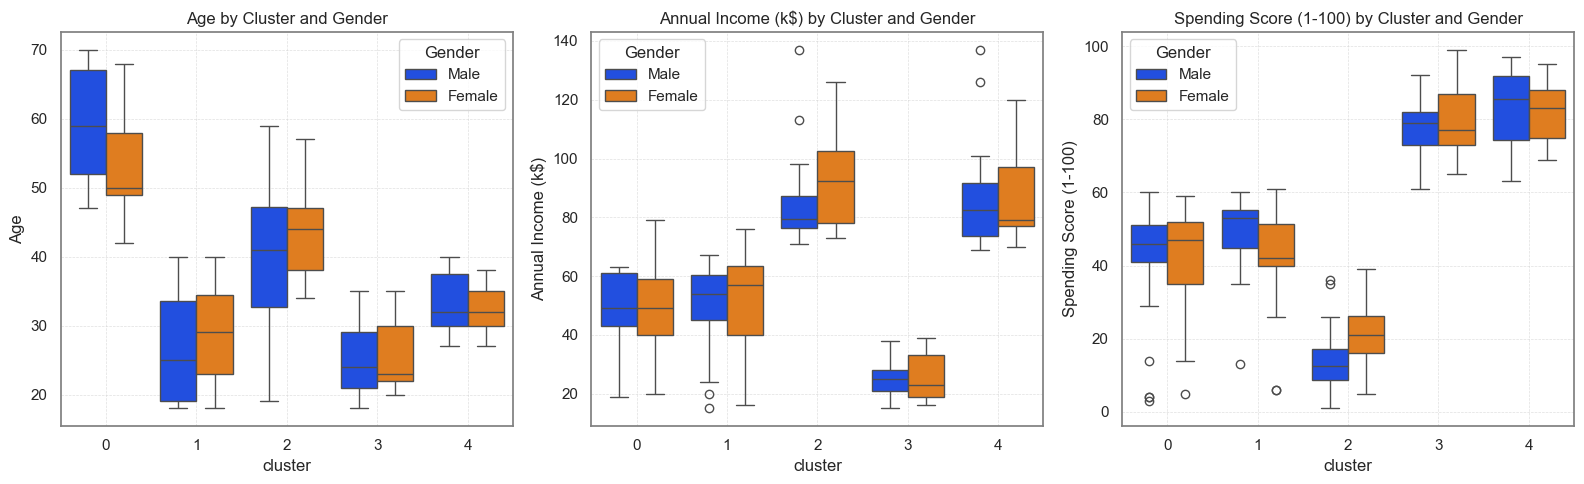

In [36]:
# Create side-by-side boxplots for each numeric variable, grouped by cluster and colored by gender

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(16, 5))

# Loop through each numeric column and create a boxplot
for ax, col in zip(axs, df_clustered.select_dtypes("number").drop(columns="cluster")):
    sns.boxplot(
        data=df_clustered,
        x="cluster",
        y=col,
        ax=ax,
        hue="Gender"
    )
    ax.set_title(f"{col} by Cluster and Gender")
    ax.set_facecolor("white")
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

plt.tight_layout()
plt.show()


In [37]:
# Contagem por cluster
counts = df_clustered["cluster"].value_counts().sort_index()
K = counts.size
n = counts.sum()
share = counts / n
expected = n / K  # tamanho "ideal" (uniforme)

# Métricas de balanceamento
chi2 = ((counts - expected)**2 / expected).sum()        # qui-quadrado vs. distribuição uniforme
try:
    from scipy.stats import chi2 as chi2dist
    pval = 1 - chi2dist.cdf(chi2, df=K-1)
except Exception:
    pval = np.nan

cv = counts.std(ddof=1) / counts.mean()                 # coeficiente de variação (↓ melhor)
hhi = (share**2).sum()                                  # Herfindahl-Hirschman (↓ melhor; min=1/K)
hhi_norm = (hhi - 1/K) / (1 - 1/K)                      # normalizado p/ [0,1]
entropy = -(share * np.log(share + 1e-12)).sum() / np.log(K)  # ↑ melhor; 1=perfeito
max_min_ratio = counts.max() / counts.min()             # 1=perfeito

summary = pd.DataFrame({
    "count": counts,
    "share": share.round(4),
    "diff_from_equal": (counts - expected).astype(int),
    "pct_diff_from_equal": (counts/expected - 1).round(3)
})
print(summary)
print(f"\nChi2 vs uniforme = {chi2:.2f} (df={K-1}), p={pval if pd.notna(pval) else 'NA'}")
print(f"CV={cv:.3f} | HHI={hhi:.4f} (norm={hhi_norm:.4f}) | Entropy={entropy:.4f} | Max/Min={max_min_ratio:.2f}")

         count  share  diff_from_equal  pct_diff_from_equal
cluster                                                    
0           58  0.290               18                0.450
1           47  0.235                7                0.175
2           34  0.170               -6               -0.150
3           22  0.110              -18               -0.450
4           39  0.195               -1               -0.025

Chi2 vs uniforme = 18.35 (df=4), p=0.0010541017793558316
CV=0.339 | HHI=0.2183 (norm=0.0229) | Entropy=0.9706 | Max/Min=2.64


In [38]:
print(df_clustered.groupby(["cluster", "Gender"]).size()) # Count observations by cluster and gender

cluster  Gender
0        Female    33
         Male      25
1        Female    31
         Male      16
2        Female    14
         Male      20
3        Female    13
         Male       9
4        Female    21
         Male      18
dtype: int64


In [39]:
df_scaled.columns

Index(['PC1', 'PC2', 'PC3'], dtype='object')

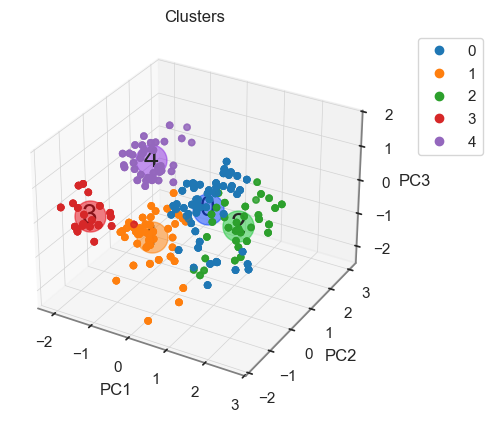

In [40]:
from functions import visualizar_clusters
visualizar_clusters(
    dataframe=df_scaled,
    colunas=['PC1', 'PC2', 'PC3'],
    quantidade_cores=5,
    centroids=centroids,
    mostrar_pontos=True,
    coluna_clusters=df_clustered["cluster"]
)

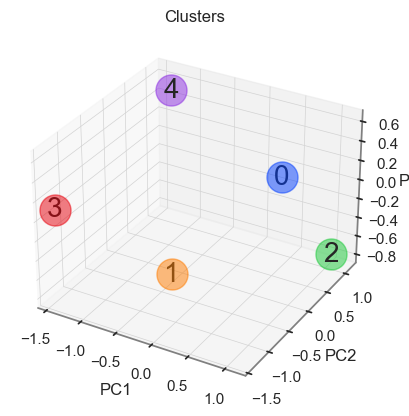

In [41]:
visualizar_clusters(
    dataframe=df_scaled,
    colunas=['PC1', 'PC2', 'PC3'],
    quantidade_cores=5,
    centroids=centroids,
)